# <font color='red' face='Times New Roman' size=15>**A Machine Learning-Based QSAR Model for Predicting Toxicity of Commercial Pesticides to** ***Eisenia fetida***</font>

## **The following is an example of building binary QSAR models in the article, due to the author's limited level, there are inevitably flaws in the modeling process, do not blame!**

### The process of building binary classification models for predicting the toxicity of pesticides to *Eisenia fetida* is shown below:

#### The versions of Python packages (except pickle) used in this study are listed below:
|Package|Version|
|:---:|:---:|
|bayesian-optimization|1.4.3|
|imbalanced-learn|0.12.3|
|lightgbm|4.4.0|
|matplotlib|3.9.0|
|mordredcommunity|2.0.6|
|numpy|1.26.4|
|pandas|2.0.0|
|rdkit|2023.9.6|
|scikit-learn|1.5.0|
|seaborn|0.13.2|
|shap|0.45.1|
|xgboost|2.1.0|
#### <font color='red' face='Times New Roman' size=15>**The environment dependencies required to execute this notebook can be quickly installed through the requirements file.**</font>

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    BaggingClassifier,
    VotingClassifier,
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization
import shap
from modeling import *  ## customizable function

plt.rcParams["axes.unicode_minus"] = False

#### Imported the dataset, calculated molecular representations; one-hot encode the pesticide formulations because we wanted to know how each formulation affected the toxicity of pesticides to *Eisenia fetida*

##### Abbreviations
|Full name|Breif name|
|:---:|:---:|
|technical material|TC|
|water-dispersible granules|WG|
|emulsifiable concentrate|EC|
|emulsion in water|EW|
|suspension concentrate|SC|
|wettable powder|WP|
|microemulsions|ME|
|water dispersible powder for slurry seed treatment|WS|
|aqueous solution|AS|
|smoke generator|FU|
|microencapsulated powder|CJ|
|capsule suspension|CS|
|oil dispersion|OD|
|effervescent tablet|PP|
|flowable concentrate for seed treatment|SD|
|water soluble granule|SG|
|soluble concentrate|SL|
|water soluble powder|SP|
|technical concentrate|TK|
|granule|GR|

In [2]:
pesticides_data = pd.read_excel(
    "dataset.xlsx", header=0, sheet_name="Binary classification"
)

model_data = compute_morgan(pesticides_data)  ##  compute count-based Morgan fingerprints

formulation = pd.get_dummies(
    model_data["Pesticide formulation"], dtype=int
)  ##  convert pesticide formulation to dummy variables
model_data = pd.concat([formulation, model_data], axis=1)
model_data.drop(
    ["Pesticide formulation", "English name", "CAS number"], axis=1, inplace=True
)

model_data

,AS,CJ,CS,EC,EW,FU,GR,ME,OD,PP,...,392737424,405833988,538880368,639743405,1247726091,2685343261,2926236081,3388977530,3529693766,4292256859
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,0,0,0,0,1,0,0,0,0,0,...,1,2,2,4,1,1,1,1,1,1
569,0,0,0,0,0,0,0,1,0,0,...,1,2,2,4,1,1,1,1,1,1
570,0,0,0,0,0,0,0,1,0,0,...,1,2,2,4,1,1,1,1,1,1
571,0,0,0,0,0,0,0,1,0,0,...,1,2,2,4,1,1,1,1,1,1


#### Stratified sampling in the ratio of 8:2 to divide the training and test sets

In [3]:
X_train, X_test, y_train, y_test = data_split(
    df=model_data, label="Toxicity level", test_size=0.2
)

extrainfo_train = X_train.iloc[:, :22].reset_index(
    drop=True
)  ##  The 22 features extracted included soil organic matter content, soil pH and 20 pesticide formulations.

extrainfo_test = X_test.iloc[:, :22].reset_index(drop=True)
# print(extrainfo_train)
# print(extrainfo_test)

y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

feature_names = X_train.columns.tolist()

#### Distribution of training and test sets

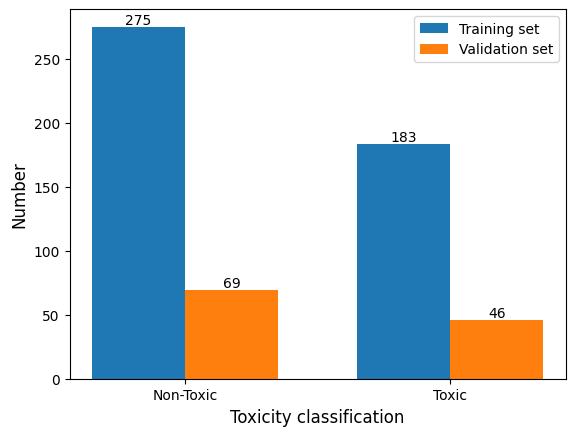

In [4]:
num0 = len(y_train[y_train == 0])
num1 = len(y_train[y_train == 1])

num2 = len(y_test[y_test == 0])
num3 = len(y_test[y_test == 1])

data1 = [num0, num1]
data2 = [num2, num3]
categories = ["Non-Toxic", "Toxic"]
bar_width = 0.35
bar_positions_group1 = np.arange(len(categories))
bar_positions_group2 = bar_positions_group1 + bar_width

plt.figure()
bars1 = plt.bar(bar_positions_group1, data1, width=bar_width, label="Training set")
for bar, data in zip(bars1, data1):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        data,
        ha="center",
        va="bottom",
    )

bars2 = plt.bar(bar_positions_group2, data2, width=bar_width, label="Validation set")
for bar, data in zip(bars2, data2):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        data,
        ha="center",
        va="bottom",
    )

plt.xticks(bar_positions_group1 + bar_width / 2, categories)
plt.xlabel("Toxicity classification", fontsize=12)
plt.ylabel("Number", fontsize=12)
plt.legend()
plt.show()

#### Use XGBoost to select the 10 most important features

In [4]:
model_select_feature = XGBClassifier(seed=0)
num_features = 10

X_train, X_test, features_selected = feature_selection(
    model_select_feature, num_features, X_train, y_train, X_test
)

print(f"We select {len(features_selected)} features as follows: \n {features_selected}")

We select 10 features as follows: 
      Features
0  1533864325
1  1791271074
2   725322217
3  2003472932
4   142531445
5  3824063894
6  1399127774
7  1688374977
8  2228063684
9    77081066


#### Feature Importance given by the XGBoost model

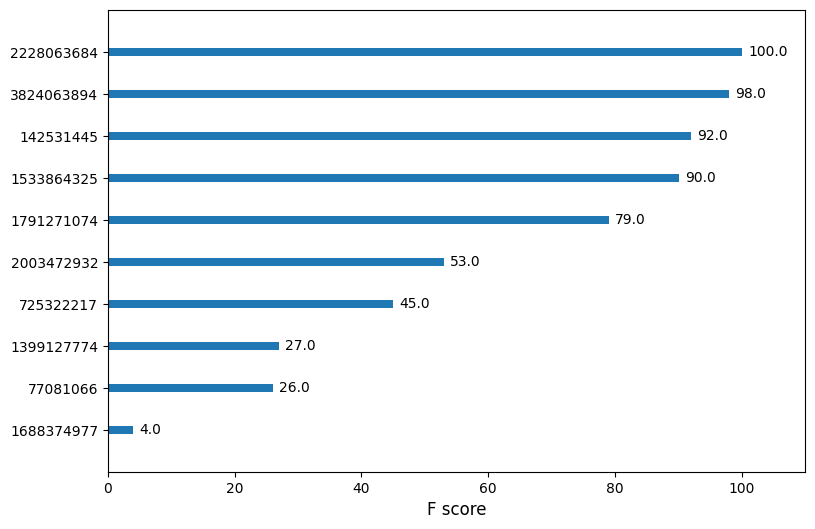

In [5]:
fig, ax = plt.subplots(figsize=(9, 6))

plot_importance(
    model_select_feature.fit(X_train, y_train),
    ax=ax,
    ylabel=None,
    title=None,
    grid=False,
)
plt.xlabel("F score", fontsize=12)

plt.show()

#### Evaluate the correlation between these 10 descriptors

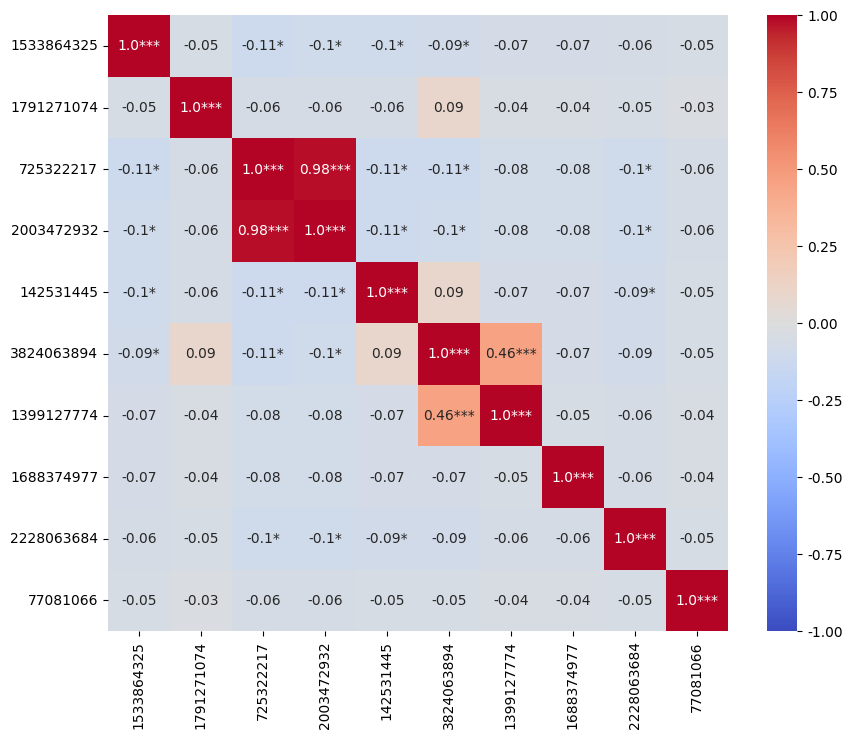

In [7]:
corr_matrix, pval_matrix = calculate_corr_pval(X_train)

annot_matrix = create_annot_matrix(corr_matrix, pval_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=annot_matrix,
    fmt="",
    annot_kws={"size": 10},
)

plt.show()

#### Remove one of the strongly correlated molecular descriptor pairs (Pearson's correlation coefficient greater than 0.8) and merge soil properties and pesticide formulations

In [8]:
X_train.drop(["725322217"], axis=1, inplace=True)
X_test.drop(["725322217"], axis=1, inplace=True)

X_train = pd.concat([X_train, extrainfo_train], axis=1)
X_test = pd.concat([X_test, extrainfo_test], axis=1)

#### Define the models; build the pipelines

In [9]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

scaler = StandardScaler()

models = [
    LogisticRegression(random_state=0),
    LinearDiscriminantAnalysis(),
    GaussianNB(),
    KNeighborsClassifier(),
    SVC(probability=True, random_state=0),
    DecisionTreeClassifier(random_state=0),
    BaggingClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    GradientBoostingClassifier(random_state=0),
    LGBMClassifier(verbose=-1, random_state=0),
]

modelnames = [
    "Logistic Regression",
    "Linear Discriminant Analysis",
    "Gaussian Naive Bayes",
    "K-nearest Neighbor",
    "Supporting Vector Machine",
    "Decision Tree",
    "Bagging",
    "Random Forest",
    "Gradient Boosting",
    "Light Gradient Boosting Machine",
]

ppls = []

for model in models:  ##  these 5 models need to be scaled before training

    if isinstance(
        model,
        (
            LogisticRegression,
            LinearDiscriminantAnalysis,
            KNeighborsClassifier,
            GaussianNB,
            SVC,
        ),
    ):
        ppl = make_pipeline(scaler, model)
        ppls.append(ppl)
    else:
        ppls.append(model)

#### Train the models with the default hyperparameters and use the test set to evaluate

Logistic Regression's results of 10-fold cross-validation are as follows: 
 [0.82608696 0.65217391 0.82608696 0.63043478 0.69565217 0.67391304
 0.86956522 0.7173913  0.73333333 0.77777778] 

Logistic Regression's mean result of 10-fold cross-validation is 0.74
Logistic Regression's Matthews Correlation Coefficient is 0.487 

Logistic Regression's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.78      0.83      0.80        69
           1       0.71      0.65      0.68        46

    accuracy                           0.76       115
   macro avg       0.75      0.74      0.74       115
weighted avg       0.75      0.76      0.75       115



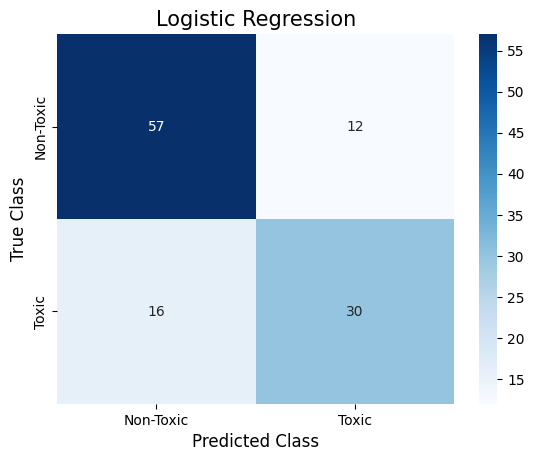

Linear Discriminant Analysis's results of 10-fold cross-validation are as follows: 
 [0.80434783 0.67391304 0.80434783 0.63043478 0.7173913  0.67391304
 0.86956522 0.76086957 0.68888889 0.8       ] 

Linear Discriminant Analysis's mean result of 10-fold cross-validation is 0.742
Linear Discriminant Analysis's Matthews Correlation Coefficient is 0.444 

Linear Discriminant Analysis's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        69
           1       0.72      0.57      0.63        46

    accuracy                           0.74       115
   macro avg       0.73      0.71      0.72       115
weighted avg       0.74      0.74      0.73       115



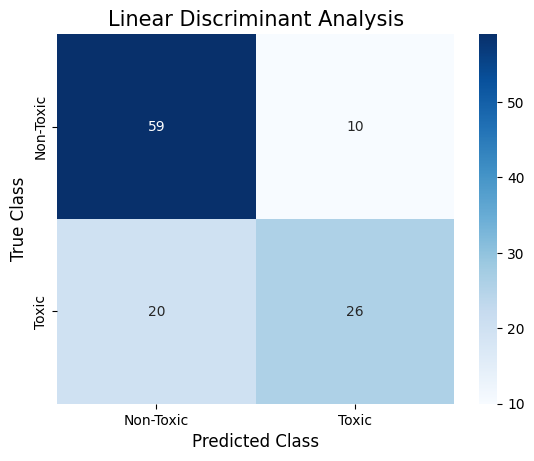

Gaussian Naive Bayes's results of 10-fold cross-validation are as follows: 
 [0.76086957 0.60869565 0.67391304 0.65217391 0.65217391 0.67391304
 0.65217391 0.65217391 0.68888889 0.64444444] 

Gaussian Naive Bayes's mean result of 10-fold cross-validation is 0.666
Gaussian Naive Bayes's Matthews Correlation Coefficient is 0.357 

Gaussian Naive Bayes's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        69
           1       1.00      0.20      0.33        46

    accuracy                           0.68       115
   macro avg       0.83      0.60      0.56       115
weighted avg       0.79      0.68      0.60       115



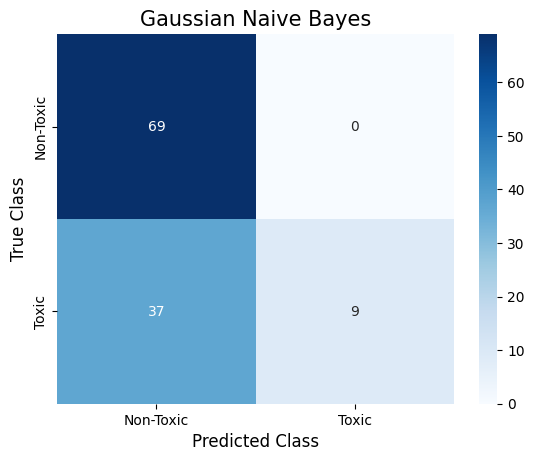

K-nearest Neighbor's results of 10-fold cross-validation are as follows: 
 [0.7173913  0.63043478 0.69565217 0.65217391 0.7173913  0.67391304
 0.84782609 0.65217391 0.66666667 0.71111111] 

K-nearest Neighbor's mean result of 10-fold cross-validation is 0.696
K-nearest Neighbor's Matthews Correlation Coefficient is 0.43 

K-nearest Neighbor's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78        69
           1       0.68      0.61      0.64        46

    accuracy                           0.73       115
   macro avg       0.72      0.71      0.71       115
weighted avg       0.73      0.73      0.73       115



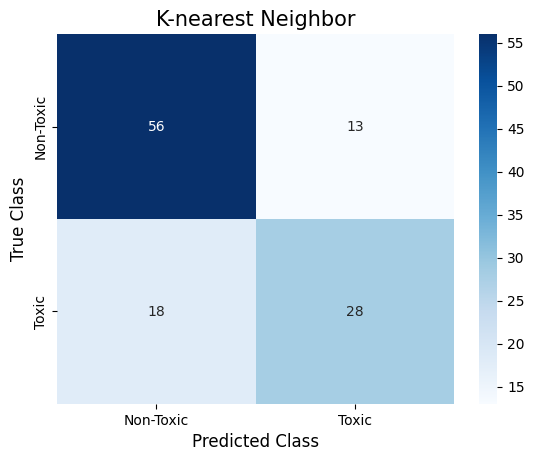

Supporting Vector Machine's results of 10-fold cross-validation are as follows: 
 [0.80434783 0.63043478 0.82608696 0.67391304 0.7173913  0.7173913
 0.82608696 0.7173913  0.68888889 0.75555556] 

Supporting Vector Machine's mean result of 10-fold cross-validation is 0.736
Supporting Vector Machine's Matthews Correlation Coefficient is 0.502 

Supporting Vector Machine's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82        69
           1       0.76      0.61      0.67        46

    accuracy                           0.77       115
   macro avg       0.76      0.74      0.75       115
weighted avg       0.76      0.77      0.76       115



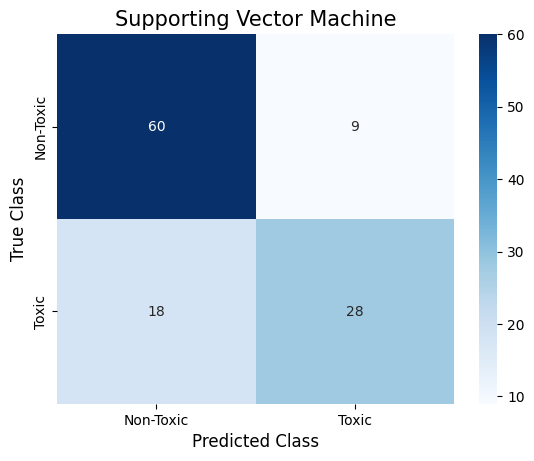

Decision Tree's results of 10-fold cross-validation are as follows: 
 [0.7826087  0.58695652 0.67391304 0.73913043 0.67391304 0.7173913
 0.82608696 0.76086957 0.62222222 0.73333333] 

Decision Tree's mean result of 10-fold cross-validation is 0.712
Decision Tree's Matthews Correlation Coefficient is 0.502 

Decision Tree's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.78      0.86      0.81        69
           1       0.74      0.63      0.68        46

    accuracy                           0.77       115
   macro avg       0.76      0.74      0.75       115
weighted avg       0.76      0.77      0.76       115



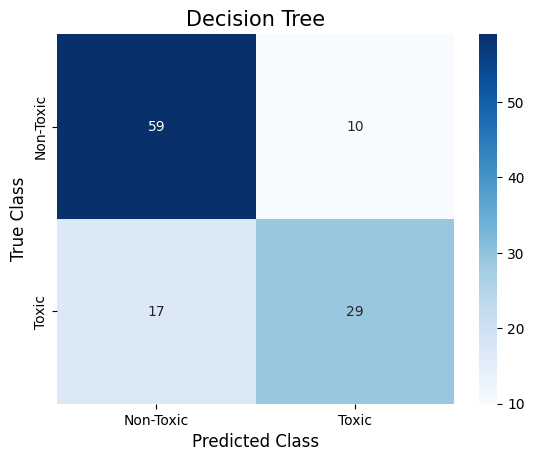

Bagging's results of 10-fold cross-validation are as follows: 
 [0.76086957 0.56521739 0.73913043 0.69565217 0.7173913  0.76086957
 0.84782609 0.84782609 0.66666667 0.73333333] 

Bagging's mean result of 10-fold cross-validation is 0.733
Bagging's Matthews Correlation Coefficient is 0.473 

Bagging's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79        69
           1       0.69      0.67      0.68        46

    accuracy                           0.75       115
   macro avg       0.74      0.74      0.74       115
weighted avg       0.75      0.75      0.75       115



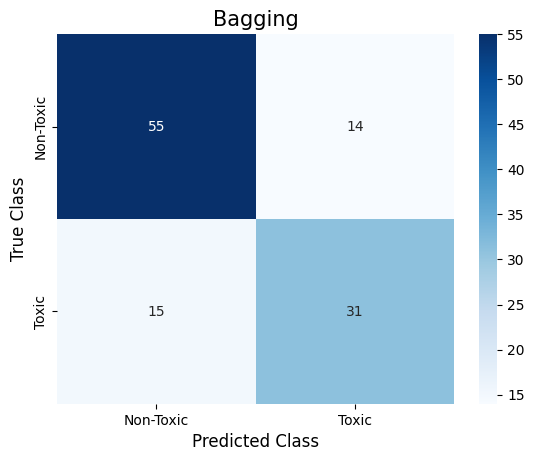

Random Forest's results of 10-fold cross-validation are as follows: 
 [0.73913043 0.63043478 0.76086957 0.69565217 0.7173913  0.76086957
 0.84782609 0.76086957 0.68888889 0.75555556] 

Random Forest's mean result of 10-fold cross-validation is 0.736
Random Forest's Matthews Correlation Coefficient is 0.578 

Random Forest's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84        69
           1       0.78      0.70      0.74        46

    accuracy                           0.80       115
   macro avg       0.80      0.78      0.79       115
weighted avg       0.80      0.80      0.80       115



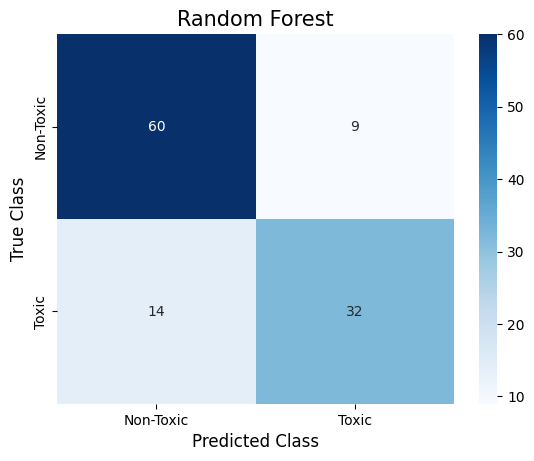

Gradient Boosting's results of 10-fold cross-validation are as follows: 
 [0.7826087  0.63043478 0.76086957 0.69565217 0.76086957 0.76086957
 0.86956522 0.7826087  0.66666667 0.82222222] 

Gradient Boosting's mean result of 10-fold cross-validation is 0.753
Gradient Boosting's Matthews Correlation Coefficient is 0.558 

Gradient Boosting's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.79      0.88      0.84        69
           1       0.79      0.65      0.71        46

    accuracy                           0.79       115
   macro avg       0.79      0.77      0.77       115
weighted avg       0.79      0.79      0.79       115



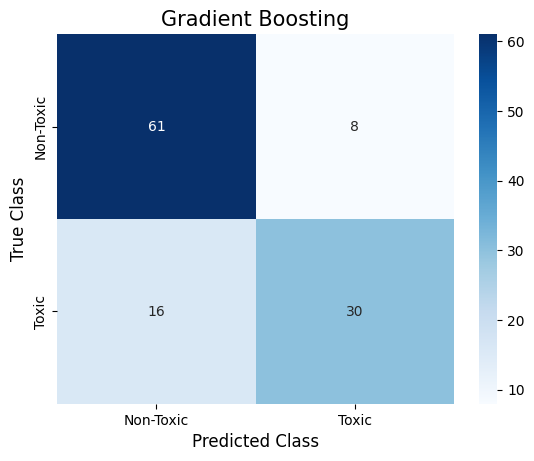

Light Gradient Boosting Machine's results of 10-fold cross-validation are as follows: 
 [0.73913043 0.63043478 0.76086957 0.7173913  0.69565217 0.7173913
 0.7826087  0.76086957 0.64444444 0.71111111] 

Light Gradient Boosting Machine's mean result of 10-fold cross-validation is 0.716
Light Gradient Boosting Machine's Matthews Correlation Coefficient is 0.482 

Light Gradient Boosting Machine's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81        69
           1       0.75      0.59      0.66        46

    accuracy                           0.76       115
   macro avg       0.75      0.73      0.73       115
weighted avg       0.76      0.76      0.75       115



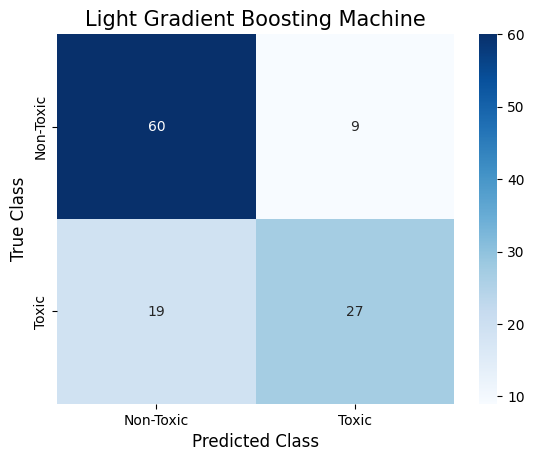

In [10]:
for ppl, name in zip(ppls, modelnames):

    print("=" * 75)
    evaluate_model(ppl, X_train, y_train, X_test, y_test, kf, name)

#### Logistic Regression, Bayesian optimization

In [41]:
def black_box_function1(C, max_iter):

    model = LogisticRegression(
        C=float(C),
        max_iter=int(max_iter),
        solver="liblinear",
        penalty="l2",
        random_state=0,
    )

    ppl = make_pipeline(scaler, model)
    cv_score = cross_val_score(ppl, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds1 = {"C": (0.1, 10), "max_iter": (50, 500)}

optimizer1 = BayesianOptimization(
    f=black_box_function1, pbounds=pbounds1, verbose=2, random_state=0
)

optimizer1.maximize(init_points=25, n_iter=75)

best_params1 = optimizer1.max["params"]
best_params1["C"] = float("%.3g" % best_params1["C"])
best_params1["max_iter"] = int(best_params1["max_iter"])

print(optimizer1.max)
print(best_params1)

|   iter    |  target   |     C     | max_iter  |
-------------------------------------------------
| 1         | 0.6467    | 5.533     | 371.8     |
| 2         | 0.6467    | 6.067     | 295.2     |
| 3         | 0.6467    | 4.294     | 340.7     |
| 4         | 0.6467    | 4.432     | 451.3     |
| 5         | 0.6436    | 9.64      | 222.5     |
| 6         | 0.6436    | 7.938     | 288.0     |
| 7         | 0.6467    | 5.724     | 466.5     |
| 8         | 0.6482    | 0.8033    | 89.21     |
| 9         | 0.6449    | 0.3002    | 424.7     |
| 10        | 0.6436    | 7.804     | 441.5     |
| 11        | 0.6436    | 9.788     | 409.6     |
| 12        | 0.6467    | 4.669     | 401.2     |
| 13        | 0.6467    | 1.271     | 338.0     |
| 14        | 0.6467    | 1.519     | 475.1     |
| 15        | 0.6467    | 5.266     | 236.6     |
| 16        | 0.6467    | 2.719     | 398.4     |
| 17        | 0.6467    | 4.616     | 305.8     |
| 18        | 0.6449    | 0.286     | 327.9     |


#### Evaluation

Logistic Regression's results of 10-fold cross-validation are as follows: 
 [0.82608696 0.65217391 0.82608696 0.63043478 0.69565217 0.67391304
 0.86956522 0.7173913  0.73333333 0.8       ] 

Logistic Regression's mean result of 10-fold cross-validation is 0.742
Logistic Regression's Matthews Correlation Coefficient is 0.47 

Logistic Regression's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79        69
           1       0.70      0.65      0.67        46

    accuracy                           0.75       115
   macro avg       0.74      0.73      0.73       115
weighted avg       0.75      0.75      0.75       115



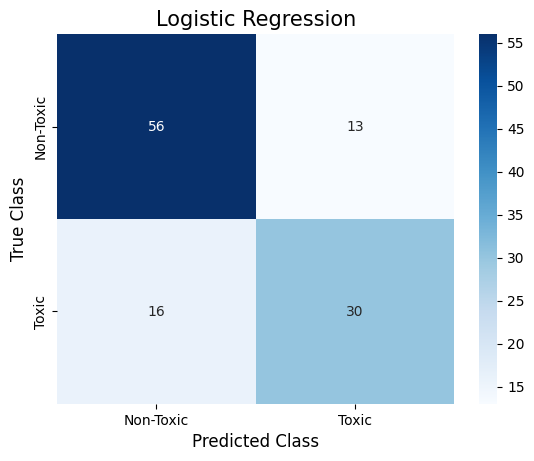

In [42]:
model_1 = LogisticRegression(
    C=best_params1["C"],
    max_iter=best_params1["max_iter"],
    solver="liblinear",
    penalty="l2",
    random_state=0,
)

ppl_1 = make_pipeline(scaler, model_1)

evaluate_model(ppl_1, X_train, y_train, X_test, y_test, kf, name="Logistic Regression")

#### LDA and GNB have fewer hyperparameters, so we do not tuned their hyperparameters

In [13]:
ppl_2 = make_pipeline(scaler, LinearDiscriminantAnalysis())
ppl_3 = make_pipeline(scaler, GaussianNB())

ppl_2.fit(X_train, y_train)
ppl_3.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gaussiannb', GaussianNB())])

#### KNN, Bayesian optimization

In [14]:
def black_box_function4(n_neighbors):

    model = KNeighborsClassifier(
        n_neighbors=int(n_neighbors),
        algorithm="brute",
    )

    ppl = make_pipeline(scaler, model)
    cv_score = cross_val_score(ppl, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds4 = {"n_neighbors": (1, 100)}

optimizer4 = BayesianOptimization(
    f=black_box_function4,
    pbounds=pbounds4,
    verbose=2,
    random_state=0,
    allow_duplicate_points=True,
)

optimizer4.maximize(init_points=25, n_iter=75)

best_params4 = optimizer4.max["params"]
best_params4["n_neighbors"] = int(best_params4["n_neighbors"])

print(optimizer4.max)
print(best_params4)

|   iter    |  target   | n_neig... |
-------------------------------------
| 1         | 0.1435    | 55.33     |
| 2         | 0.01      | 71.8      |
| 3         | 0.09957   | 60.67     |
| 4         | 0.154     | 54.94     |
| 5         | 0.2496    | 42.94     |
| 6         | 0.05063   | 64.94     |
| 7         | 0.2388    | 44.32     |
| 8         | 0.0       | 89.29     |
| 9         | 0.0       | 96.4      |
| 10        | 0.3686    | 38.96     |
| 11        | 0.0       | 79.38     |
| 12        | 0.1718    | 53.36     |
| 13        | 0.1635    | 57.24     |
| 14        | 0.0       | 92.63     |
| 15        | 0.5123    | 8.033     |
| 16        | 0.5632    | 9.626     |
| 17        | 0.5938    | 3.002     |
| 18        | 0.0       | 83.43     |
| 19        | 0.01053   | 78.04     |
| 20        | 0.0       | 87.13     |
| 21        | 0.0       | 97.88     |
| 22        | 0.0       | 80.12     |
| 23        | 0.2046    | 46.69     |
| 24        | 0.01053   | 78.27     |
| 25        

#### Evaluation

KNN's results of 10-fold cross-validation are as follows: 
 [0.76086957 0.58695652 0.73913043 0.82608696 0.65217391 0.73913043
 0.89130435 0.73913043 0.66666667 0.71111111] 

KNN's mean result of 10-fold cross-validation is 0.731
KNN's Matthews Correlation Coefficient is 0.509 

KNN's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81        69
           1       0.71      0.70      0.70        46

    accuracy                           0.77       115
   macro avg       0.76      0.75      0.75       115
weighted avg       0.76      0.77      0.76       115



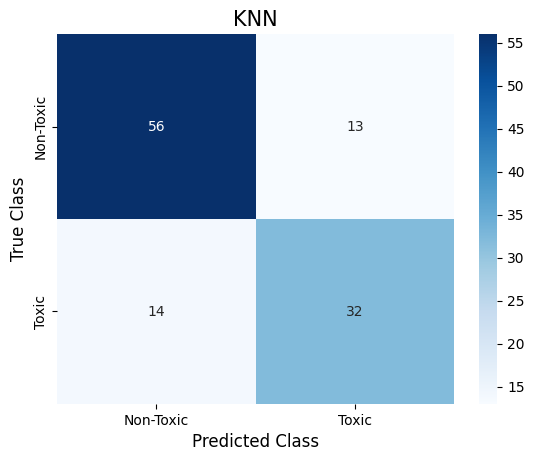

In [15]:
model_4 = KNeighborsClassifier(
    n_neighbors=best_params4["n_neighbors"],
    algorithm="brute",
)

ppl_4 = make_pipeline(scaler, model_4)

evaluate_model(ppl_4, X_train, y_train, X_test, y_test, kf, name="KNN")

#### SVC, Bayesian optimization

In [39]:
def black_box_function5(C, gamma):

    model = SVC(
        C=float(C), gamma=float(gamma), kernel="rbf", probability=True, random_state=0
    )

    ppl = make_pipeline(scaler, model)
    cv_score = cross_val_score(ppl, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds5 = {"C": (1e-3, 1), "gamma": (1e-3, 1)}

optimizer5 = BayesianOptimization(
    f=black_box_function5, pbounds=pbounds5, verbose=2, random_state=0
)

optimizer5.maximize(init_points=25, n_iter=75)

best_params5 = optimizer5.max["params"]

best_params5["C"] = float("%.3g" % best_params5["C"])
best_params5["gamma"] = float("%.3g" % best_params5["gamma"])

print(optimizer5.max)
print(best_params5)

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.4976    | 0.5493    | 0.7155    |
| 2         | 0.5987    | 0.6032    | 0.5453    |
| 3         | 0.3205    | 0.4242    | 0.6462    |
| 4         | 0.3012    | 0.4381    | 0.8919    |
| 5         | 0.6463    | 0.9637    | 0.3841    |
| 6         | 0.6504    | 0.7919    | 0.5294    |
| 7         | 0.3834    | 0.5685    | 0.9257    |
| 8         | 0.0       | 0.07197   | 0.08804   |
| 9         | 0.0       | 0.0212    | 0.8328    |
| 10        | 0.5985    | 0.7784    | 0.8701    |
| 11        | 0.6524    | 0.9786    | 0.7994    |
| 12        | 0.3273    | 0.462     | 0.7807    |
| 13        | 0.0       | 0.1192    | 0.6403    |
| 14        | 0.0       | 0.1442    | 0.9447    |
| 15        | 0.5866    | 0.5223    | 0.4152    |
| 16        | 0.05844   | 0.2653    | 0.7745    |
| 17        | 0.4205    | 0.4567    | 0.5689    |
| 18        | 0.0       | 0.01977   | 0.618     |


#### Evaluation

SVC's results of 10-fold cross-validation are as follows: 
 [0.84782609 0.63043478 0.80434783 0.7173913  0.69565217 0.73913043
 0.86956522 0.69565217 0.64444444 0.73333333] 

SVC's mean result of 10-fold cross-validation is 0.738
SVC's Matthews Correlation Coefficient is 0.553 

SVC's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81        69
           1       0.71      0.76      0.74        46

    accuracy                           0.78       115
   macro avg       0.77      0.78      0.78       115
weighted avg       0.79      0.78      0.78       115



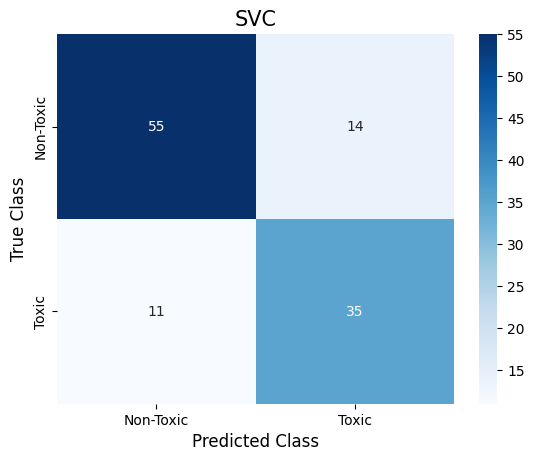

In [40]:
model_5 = SVC(
    C=best_params5["C"],
    gamma=best_params5["gamma"],
    kernel="rbf",
    probability=True,
    random_state=0,
)

ppl_5 = make_pipeline(scaler, model_5)

evaluate_model(ppl_5, X_train, y_train, X_test, y_test, kf, "SVC")

#### Decision Tree, Bayesian optimization

In [18]:
def black_box_function6(max_depth, max_features, min_samples_split, min_samples_leaf):

    model = DecisionTreeClassifier(
        max_depth=int(max_depth),
        max_features=int(max_features),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        random_state=0,
    )

    cv_score = cross_val_score(model, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds6 = {
    "max_depth": (1, 31),
    "max_features": (1, 31),
    "min_samples_split": (2, 50),
    "min_samples_leaf": (1, 50),
}

optimizer6 = BayesianOptimization(
    f=black_box_function6,
    pbounds=pbounds6,
    random_state=0,
)

optimizer6.maximize(init_points=25, n_iter=75)

best_params6 = optimizer6.max["params"]

best_params6["max_depth"] = int(best_params6["max_depth"])
best_params6["max_features"] = int(best_params6["max_features"])
best_params6["min_samples_split"] = int(best_params6["min_samples_split"])
best_params6["min_samples_leaf"] = int(best_params6["min_samples_leaf"])

print(optimizer6.max)
print(best_params6)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... |
-------------------------------------------------------------------------
| 1         | 0.5704    | 17.46     | 22.46     | 30.54     | 28.15     |
| 2         | 0.5232    | 13.71     | 20.38     | 22.44     | 44.81     |
| 3         | 0.2653    | 29.91     | 12.5      | 39.79     | 27.39     |
| 4         | 0.6066    | 18.04     | 28.77     | 4.481     | 6.182     |
| 5         | 0.02857   | 1.607     | 25.98     | 39.13     | 43.76     |
| 6         | 0.5169    | 30.36     | 24.97     | 23.61     | 39.47     |
| 7         | 0.51      | 4.548     | 20.2      | 8.024     | 47.34     |
| 8         | 0.52      | 16.66     | 13.44     | 13.96     | 39.16     |
| 9         | 0.5772    | 14.68     | 18.05     | 1.921     | 31.65     |
| 10        | 0.0       | 19.36     | 19.51     | 47.24     | 34.73     |
| 11        | 0.2344    | 11.79     | 14.11     | 35.18     | 4.891     |
| 12        | 0.5592    | 21.0      | 

#### Evaluation

Decision Tree's results of 10-fold cross-validation are as follows: 
 [0.80434783 0.69565217 0.82608696 0.76086957 0.7173913  0.73913043
 0.7826087  0.73913043 0.73333333 0.77777778] 

Decision Tree's mean result of 10-fold cross-validation is 0.758
Decision Tree's Matthews Correlation Coefficient is 0.521 

Decision Tree's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        69
           1       0.78      0.61      0.68        46

    accuracy                           0.77       115
   macro avg       0.77      0.75      0.75       115
weighted avg       0.77      0.77      0.77       115



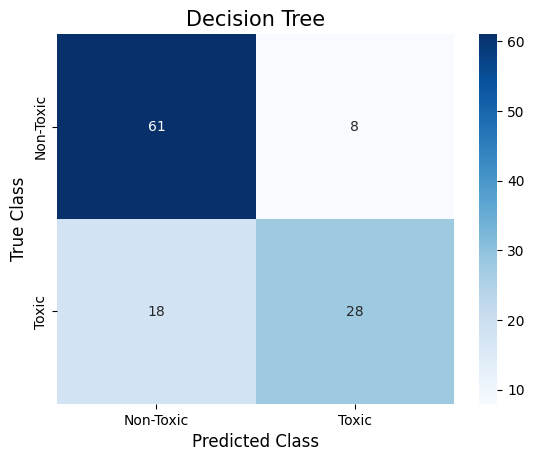

In [19]:
model_6 = DecisionTreeClassifier(
    max_depth=best_params6["max_depth"],
    max_features=best_params6["max_features"],
    min_samples_split=best_params6["min_samples_split"],
    min_samples_leaf=best_params6["min_samples_leaf"],
    random_state=0,
)

evaluate_model(model_6, X_train, y_train, X_test, y_test, kf, name="Decision Tree")

#### Bagging, Bayesian optimization

In [20]:
def black_box_function7(n_estimators, max_samples, max_features):

    model = BaggingClassifier(
        n_estimators=int(n_estimators),
        max_samples=int(max_samples),
        max_features=int(max_features),
        random_state=0,
    )

    cv_score = cross_val_score(model, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds7 = {"n_estimators": (50, 500), "max_samples": (1, 100), "max_features": (1, 31)}

optimizer7 = BayesianOptimization(
    f=black_box_function7, pbounds=pbounds7, verbose=2, random_state=0
)

optimizer7.maximize(init_points=25, n_iter=75)

best_params7 = optimizer7.max["params"]
best_params7["n_estimators"] = int(best_params7["n_estimators"])
best_params7["max_samples"] = int(best_params7["max_samples"])
best_params7["max_features"] = int(best_params7["max_features"])

print(optimizer7.max)
print(best_params7)

|   iter    |  target   | max_fe... | max_sa... | n_esti... |
-------------------------------------------------------------
| 1         | 0.6105    | 17.46     | 71.8      | 321.2     |
| 2         | 0.5982    | 17.35     | 42.94     | 340.7     |
| 3         | 0.595     | 14.13     | 89.29     | 483.6     |
| 4         | 0.5629    | 12.5      | 79.38     | 288.0     |
| 5         | 0.607     | 18.04     | 92.63     | 81.97     |
| 6         | 0.0       | 3.614     | 3.002     | 424.7     |
| 7         | 0.625     | 24.34     | 87.13     | 490.4     |
| 8         | 0.5869    | 24.97     | 46.69     | 401.2     |
| 9         | 0.3001    | 4.548     | 64.35     | 114.5     |
| 10        | 0.6039    | 29.34     | 52.66     | 236.6     |
| 11        | 0.5001    | 8.937     | 77.65     | 255.3     |
| 12        | 0.0       | 18.05     | 2.86      | 327.9     |
| 13        | 0.5975    | 19.36     | 62.08     | 474.7     |
| 14        | 0.5896    | 21.45     | 36.59     | 246.7     |
| 15    

#### Evaluation

Bagging's results of 10-fold cross-validation are as follows: 
 [0.7826087  0.58695652 0.80434783 0.7173913  0.69565217 0.73913043
 0.84782609 0.82608696 0.68888889 0.8       ] 

Bagging's mean result of 10-fold cross-validation is 0.749
Bagging's Matthews Correlation Coefficient is 0.559 

Bagging's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84        69
           1       0.81      0.63      0.71        46

    accuracy                           0.79       115
   macro avg       0.80      0.76      0.77       115
weighted avg       0.79      0.79      0.79       115



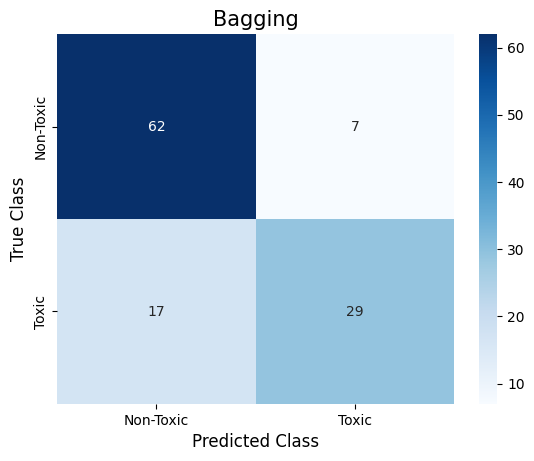

In [21]:
model_7 = BaggingClassifier(
    n_estimators=best_params7["n_estimators"],
    max_samples=best_params7["max_samples"],
    max_features=best_params7["max_features"],
    random_state=0,
)

evaluate_model(model_7, X_train, y_train, X_test, y_test, kf, "Bagging")

#### Random Forest, Bayesian optimization

In [22]:
def black_box_function8(
    n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features
):

    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        max_features=int(max_features),
        n_jobs=-1,
        random_state=0,
    )

    cv_score = cross_val_score(model, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds8 = {
    "n_estimators": (50, 500),
    "max_depth": (1, 31),
    "min_samples_split": (2, 50),
    "min_samples_leaf": (1, 50),
    "max_features": (1, 31),
}

optimizer8 = BayesianOptimization(
    f=black_box_function8, pbounds=pbounds8, verbose=2, random_state=0
)

optimizer8.maximize(init_points=25, n_iter=75)

best_params8 = optimizer8.max["params"]
best_params8["n_estimators"] = int(best_params8["n_estimators"])
best_params8["max_depth"] = int(best_params8["max_depth"])
best_params8["min_samples_split"] = int(best_params8["min_samples_split"])
best_params8["min_samples_leaf"] = int(best_params8["min_samples_leaf"])
best_params8["max_features"] = int(best_params8["max_features"])

print("Optimized parameters:", optimizer8.max)
print(best_params8)

|   iter    |  target   | max_depth | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.3938    | 17.46     | 22.46     | 30.54     | 28.15     | 240.6     |
| 2         | 0.2183    | 20.38     | 14.13     | 44.7      | 48.26     | 222.5     |
| 3         | 0.4067    | 24.75     | 16.87     | 28.83     | 46.43     | 81.97     |
| 4         | 0.0       | 3.614     | 1.607     | 41.8      | 39.35     | 441.5     |
| 5         | 0.5398    | 30.36     | 24.97     | 23.61     | 39.47     | 103.2     |
| 6         | 0.0       | 20.2      | 5.301     | 47.29     | 27.05     | 236.6     |
| 7         | 0.5313    | 8.937     | 24.23     | 23.35     | 29.28     | 58.46     |
| 8         | 0.3871    | 19.53     | 19.36     | 31.23     | 47.3      | 356.8     |
| 9         | 0.1856    | 11.79     | 14.11     | 35.18     | 4.891     | 350.0     |
| 10        | 0.5797    | 21.12     | 7.311     | 7.31

#### Evaluation

Random Forest's results of 10-fold cross-validation are as follows: 
 [0.80434783 0.65217391 0.86956522 0.69565217 0.73913043 0.76086957
 0.89130435 0.73913043 0.68888889 0.84444444] 

Random Forest's mean result of 10-fold cross-validation is 0.769
Random Forest's Matthews Correlation Coefficient is 0.54 

Random Forest's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        69
           1       0.78      0.63      0.70        46

    accuracy                           0.78       115
   macro avg       0.78      0.76      0.76       115
weighted avg       0.78      0.78      0.78       115



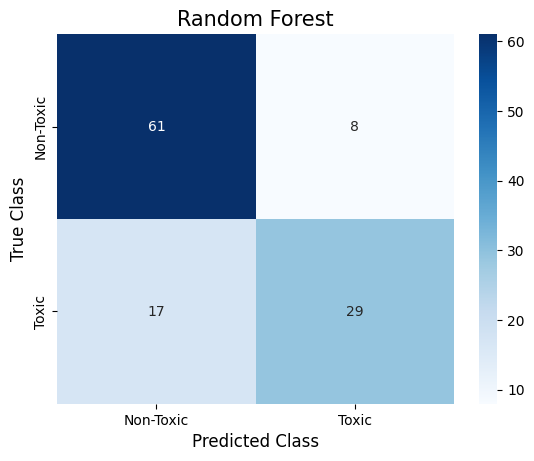

In [23]:
model_8 = RandomForestClassifier(
    n_estimators=best_params8["n_estimators"],
    max_depth=best_params8["max_depth"],
    min_samples_leaf=best_params8["min_samples_leaf"],
    min_samples_split=best_params8["min_samples_split"],
    max_features=best_params8["max_features"],
    n_jobs=-1,
    random_state=0,
)

evaluate_model(model_8, X_train, y_train, X_test, y_test, kf, "Random Forest")

#### GBDT, Bayesian optimization

In [24]:
def black_box_function9(
    n_estimators,
    learning_rate,
    max_depth,
    max_features,
    min_samples_split,
    min_samples_leaf,
    subsample,
):

    model = GradientBoostingClassifier(
        n_estimators=int(n_estimators),
        learning_rate=float(learning_rate),
        max_depth=int(max_depth),
        max_features=int(max_features),
        min_samples_split=int(min_samples_split),
        min_samples_leaf=int(min_samples_leaf),
        subsample=float(subsample),
        random_state=0,
    )

    cv_score = cross_val_score(model, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds9 = {
    "n_estimators": (50, 500),
    "learning_rate": (0.01, 0.3),
    "max_depth": (1, 31),
    "max_features": (1, 31),
    "min_samples_split": (2, 50),
    "min_samples_leaf": (1, 50),
    "subsample": (0.1, 1),
}

optimizer9 = BayesianOptimization(
    f=black_box_function9, pbounds=pbounds9, verbose=2, random_state=0
)

optimizer9.maximize(init_points=25, n_iter=75)

best_params9 = optimizer9.max["params"]
best_params9["n_estimators"] = int(best_params9["n_estimators"])
best_params9["learning_rate"] = float("%.3g" % best_params9["learning_rate"])
best_params9["max_depth"] = int(best_params9["max_depth"])
best_params9["max_features"] = int(best_params9["max_features"])
best_params9["min_samples_split"] = int(best_params9["min_samples_split"])
best_params9["min_samples_leaf"] = int(best_params9["min_samples_leaf"])
best_params9["subsample"] = float("%.3g" % best_params9["subsample"])

print(optimizer9.max)
print(best_params9)

|   iter    |  target   | learni... | max_depth | max_fe... | min_sa... | min_sa... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.5063    | 0.1692    | 22.46     | 19.08     | 27.7      | 22.34     | 340.7     | 0.4938    |
| 2         | 0.4739    | 0.2686    | 29.91     | 12.5      | 39.79     | 27.39     | 305.6     | 0.933     |
| 3         | 0.06814   | 0.0306    | 3.614     | 1.607     | 41.8      | 39.35     | 441.5     | 0.9808    |
| 4         | 0.6283    | 0.2418    | 14.84     | 24.42     | 6.795     | 32.72     | 114.5     | 0.9502    |
| 5         | 0.0       | 0.1613    | 13.44     | 8.937     | 38.94     | 23.9      | 305.8     | 0.1169    |
| 6         | 0.4489    | 0.1891    | 19.36     | 19.51     | 47.24     | 34.73     | 211.8     | 0.4933    |
| 7         | 0.3742    | 0.2123    | 2.807     | 21.0      | 33.86     | 12.1      | 108.0     | 0.3839    |
| 8       

#### Evaluation

GBDT's results of 10-fold cross-validation are as follows: 
 [0.82608696 0.60869565 0.82608696 0.69565217 0.7173913  0.69565217
 0.89130435 0.7173913  0.73333333 0.86666667] 

GBDT's mean result of 10-fold cross-validation is 0.758
GBDT's Matthews Correlation Coefficient is 0.58 

GBDT's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        69
           1       0.77      0.72      0.74        46

    accuracy                           0.80       115
   macro avg       0.79      0.79      0.79       115
weighted avg       0.80      0.80      0.80       115



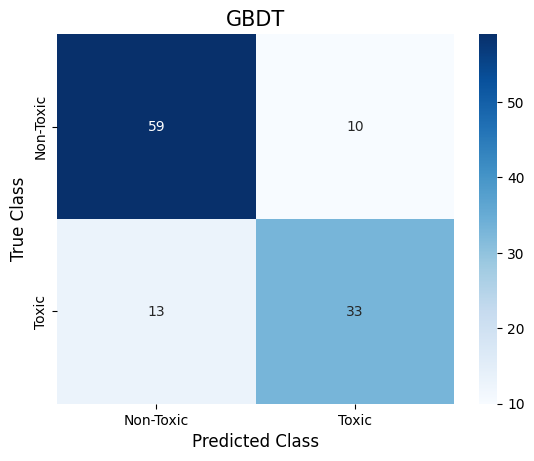

In [25]:
model_9 = GradientBoostingClassifier(
    n_estimators=best_params9["n_estimators"],
    learning_rate=best_params9["learning_rate"],
    max_depth=best_params9["max_depth"],
    max_features=best_params9["max_features"],
    min_samples_split=best_params9["min_samples_split"],
    min_samples_leaf=best_params9["min_samples_leaf"],
    subsample=best_params9["subsample"],
    random_state=0,
)

evaluate_model(model_9, X_train, y_train, X_test, y_test, kf, "GBDT")

#### LightGBM, Bayesian optimization

In [26]:
def black_box_function10(
    n_estimators,
    learning_rate,
    num_leaves,
    max_depth,
    min_child_samples,
    subsample,
    colsample_bytree,
    reg_alpha,
    reg_lambda,
):

    model = LGBMClassifier(
        n_estimators=int(n_estimators),
        learning_rate=float(learning_rate),
        max_depth=int(max_depth),
        num_leaves=int(num_leaves),
        min_child_samples=int(min_child_samples),
        subsample=float(subsample),
        colsample_bytree=float(colsample_bytree),
        reg_alpha=float(reg_alpha),
        reg_lambda=float(reg_lambda),
        verbose=-1,
        n_jobs=-1,
        random_state=0,
    )

    cv_score = cross_val_score(model, X_train, y_train, cv=kf, scoring="f1")

    return cv_score.mean()


pbounds10 = {
    "n_estimators": (50, 500),
    "learning_rate": (0.01, 0.3),
    "max_depth": (1, 31),
    "num_leaves": (2, 1024),
    "min_child_samples": (1, 50),
    "subsample": (0.1, 1),
    "colsample_bytree": (0.1, 1),
    "reg_alpha": (0, 1),
    "reg_lambda": (0, 1),
}

optimizer10 = BayesianOptimization(
    f=black_box_function10, pbounds=pbounds10, verbose=2, random_state=0
)

optimizer10.maximize(init_points=25, n_iter=75)

best_params10 = optimizer10.max["params"]
best_params10["n_estimators"] = int(best_params10["n_estimators"])
best_params10["learning_rate"] = float("%.3g" % best_params10["learning_rate"])
best_params10["max_depth"] = int(best_params10["max_depth"])
best_params10["num_leaves"] = int(best_params10["num_leaves"])
best_params10["min_child_samples"] = int(best_params10["min_child_samples"])
best_params10["subsample"] = float("%.3g" % best_params10["subsample"])
best_params10["colsample_bytree"] = float("%.3g" % best_params10["colsample_bytree"])
best_params10["reg_alpha"] = float("%.3g" % best_params10["reg_alpha"])
best_params10["reg_lambda"] = float("%.3g" % best_params10["reg_lambda"])

print(optimizer10.max)
print(best_params10)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.6542    | 0.5939    | 0.2174    | 19.08     | 27.7      | 240.6     | 662.1     | 0.4376    | 0.8918    | 0.9673    |
| 2         | 0.6339    | 0.4451    | 0.2396    | 16.87     | 28.83     | 466.5     | 74.6      | 0.08713   | 0.02022   | 0.8494    |
| 3         | 0.468     | 0.8003    | 0.2623    | 30.36     | 40.16     | 257.7     | 799.7     | 0.1183    | 0.6399    | 0.229     |
| 4         | 0.6355    | 0.9502    | 0.1613    | 13.44     | 13.96     | 398.4     | 468.2     | 0.5684    | 0.01879   | 0.6559    |
| 5         | 0.5881    | 0.6509    | 0.1889    | 29.31     | 34.41     | 211.8     | 448.6     | 0.6976    | 0.06023   | 0.7001    |
| 6         | 0.6416    | 0.7036    | 0.07101   | 4.868     | 

#### Evaluation

LightGBM's results of 10-fold cross-validation are as follows: 
 [0.82608696 0.56521739 0.82608696 0.69565217 0.67391304 0.73913043
 0.86956522 0.7173913  0.68888889 0.88888889] 

LightGBM's mean result of 10-fold cross-validation is 0.749
LightGBM's Matthews Correlation Coefficient is 0.444 

LightGBM's performance on test set is as follows:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        69
           1       0.72      0.57      0.63        46

    accuracy                           0.74       115
   macro avg       0.73      0.71      0.72       115
weighted avg       0.74      0.74      0.73       115



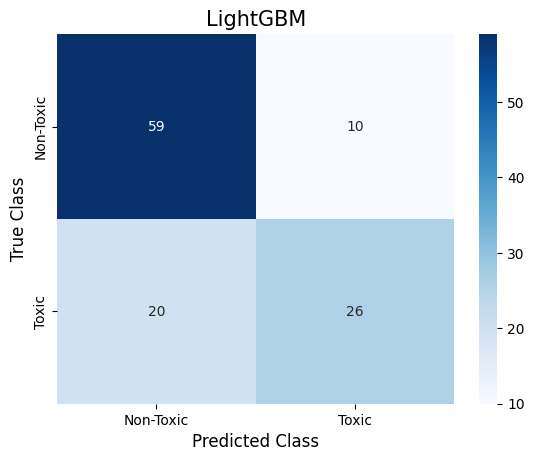

In [27]:
model_10 = LGBMClassifier(
    n_estimators=best_params10["n_estimators"],
    learning_rate=best_params10["learning_rate"],
    max_depth=best_params10["max_depth"],
    num_leaves=best_params10["num_leaves"],
    subsample=best_params10["subsample"],
    colsample_bytree=best_params10["colsample_bytree"],
    min_child_samples=best_params10["min_child_samples"],
    reg_alpha=best_params10["reg_alpha"],
    reg_lambda=best_params10["reg_lambda"],
    n_jobs=-1,
    verbosity=-1,
    random_state=0,
)

evaluate_model(model_10, X_train, y_train, X_test, y_test, kf, "LightGBM")

#### Use K-nearest Neighbor method to define the applicability domain

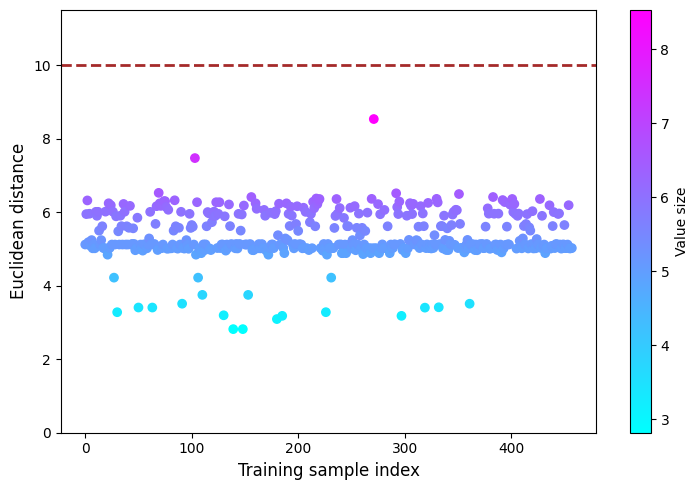

In [36]:
train_set_numeric = np.array(X_train)

dt_train_values = calculate_train_dt(train_set_numeric)

threshold = 10

plt.figure(figsize=(7.5, 5))
plt.scatter(
    range(len(dt_train_values)), dt_train_values, c=dt_train_values, cmap="cool"
)
plt.axhline(y=threshold, color="brown", linestyle="--", linewidth=2)
plt.colorbar(label="Value size")
plt.xlabel("Training sample index", fontsize=12)
plt.ylabel("Euclidean distance", fontsize=12)
plt.ylim(0, 11.5)
plt.tight_layout()

plt.show()

#### Observe whether the samples in the test set are contained within the applicability domain

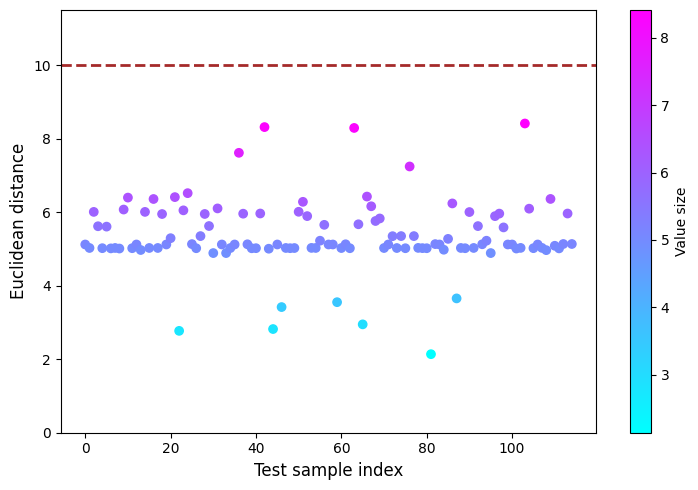

In [37]:
test_set_numeric = np.array(X_test)
dt_values_test = calculate_test_dt(test_set_numeric, train_set_numeric)

plt.figure(figsize=(7.5, 5))
plt.scatter(range(len(dt_values_test)), dt_values_test, c=dt_values_test, cmap="cool")
plt.axhline(y=threshold, color="brown", linestyle="--", linewidth=2)
plt.colorbar(label="Value size")
plt.xlabel("Test sample index", fontsize=12)
plt.ylabel("Euclidean distance", fontsize=12)
plt.ylim(0, 11.5)
plt.tight_layout()

plt.show()

#### Use pickle to save the models

In [43]:
clfs = [model_10, model_9, model_8, model_7, model_6, ppl_5, ppl_4, ppl_3, ppl_2, ppl_1]

clfnames = [
    "LightGBM_2class_morgan",
    "GBDT_2class_morgan",
    "RF_2class_morgan",
    "Bagging_2class_morgan",
    "DT_2class_morgan",
    "SVC_2class_morgan",
    "KNN_2class_morgan",
    "GNB_2class_morgan",
    "LDA_2class_morgan",
    "LR_2class_morgan",
]

for clf, name in zip(clfs, clfnames):
    with open(name, "wb") as f:
        pickle.dump(clf, f)

#### Use pickle to load the models

In [44]:
loaded_models = []

clfnames = [
    "LightGBM_2class_morgan",
    "GBDT_2class_morgan",
    "RF_2class_morgan",
    "Bagging_2class_morgan",
    "DT_2class_morgan",
    "SVC_2class_morgan",
    "KNN_2class_morgan",
    "GNB_2class_morgan",
    "LDA_2class_morgan",
    "LR_2class_morgan",
]

for name in clfnames:
    with open(name, "rb") as f:
        model = pickle.load(f)
        loaded_models.append(model)

#### Verify that the imported models are correct

In [45]:
modelnames = [
    "LightGBM",
    "GBDT",
    "RF",
    "Bagging",
    "DT",
    "SVC",
    "KNN",
    "GNB",
    "LDA",
    "LR",
]

df_cv_scores = {}

for model, name in zip(loaded_models, modelnames):

    y_predict = model.predict(X_test)

    cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
    df_cv_scores[name] = cv_scores
    acc = cv_scores.mean()
    report = classification_report(y_test, y_predict)

    print(f"{name}'s 10-fold cross-validation accuracy:\n{cv_scores}")
    print(f"\n{name}'s accuracy is {acc:.3g} (training set)")
    print(f"{name}'s classification report:\n{report}")
    print("=" * 75)

df_cv_scores = pd.DataFrame(df_cv_scores)

LightGBM's 10-fold cross-validation accuracy:
[0.82608696 0.56521739 0.82608696 0.69565217 0.67391304 0.73913043
 0.86956522 0.7173913  0.68888889 0.88888889]

LightGBM's accuracy is 0.749 (training set)
LightGBM's classification report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80        69
           1       0.72      0.57      0.63        46

    accuracy                           0.74       115
   macro avg       0.73      0.71      0.72       115
weighted avg       0.74      0.74      0.73       115

GBDT's 10-fold cross-validation accuracy:
[0.82608696 0.60869565 0.82608696 0.69565217 0.7173913  0.69565217
 0.89130435 0.7173913  0.73333333 0.86666667]

GBDT's accuracy is 0.758 (training set)
GBDT's classification report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        69
           1       0.77      0.72      0.74        46

    accuracy                           0.80  

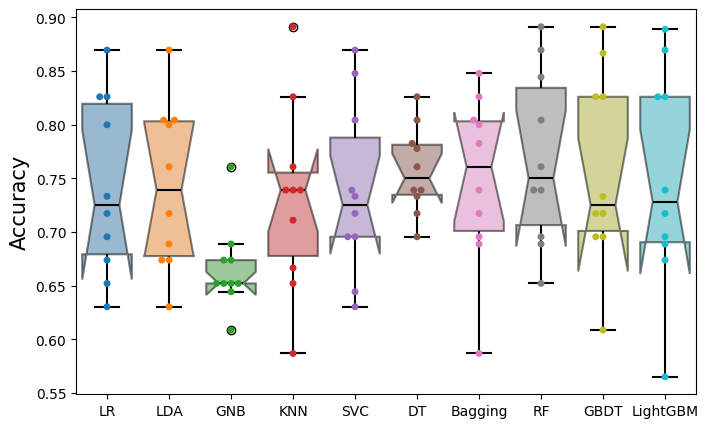

In [46]:
vars = ["LR", "LDA", "GNB", "KNN", "SVC", "DT", "Bagging", "RF", "GBDT", "LightGBM"]
df_cv_scores = df_cv_scores.melt(
    value_vars=vars, var_name="Algorithm", value_name="Accuracy"
)

plt.figure(figsize=(8, 5))

boxprops = {"alpha": 0.5}

sns.boxplot(
    df_cv_scores,
    x="Algorithm",
    y="Accuracy",
    hue="Algorithm",
    linecolor="black",
    linewidth=1.5,
    notch=True,
    boxprops=boxprops,
)
sns.swarmplot(df_cv_scores, x="Algorithm", y="Accuracy", hue="Algorithm", legend=None)

plt.xlabel("")
plt.ylabel("Accuracy", fontsize=15)

plt.show()